# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [151]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [152]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
16643,24061,69013,USA,24-03-2020,#PPE \r\r\n#Coronavirus\r\r\n#CoronavirusOutbr...,Extremely Positive
9749,15637,60589,in Wonderland..,20-03-2020,Just passed by a restaurant and a coffee shop ...,Negative
24868,34237,79189,Northern VA,06-04-2020,Video: As many people have already pointed out...,Positive
19158,27117,72069,"New Delhi, India",25-03-2020,Release Amulya! \r\r\n\r\r\nRs. 1.2 Trillion C...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [153]:
df['Sentiment'] = (df['Sentiment'] == 'Positive').astype(int)

In [154]:
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
8474,14108,59060,NaN,20-03-2020,Going to supermarket tomorrow. Had hell of a w...,0
9391,15201,60153,"Liverpool, England",20-03-2020,This is what happened here in spain... first t...,0
224,4069,49021,"Orange County, CA",16-03-2020,Consumer response to #cannabisindustry during ...,1
25050,34470,79422,"Lagos, Nigeria",06-04-2020,I canÃÂt believe I didnÃÂt buy any thing f...,1


Сбалансированы ли классы?

In [155]:
df.groupby(['Sentiment']).agg('count').iloc[:, 0]

Sentiment
0    22022
1    11422
Name: UserName, dtype: int64

**Ответ:** Нет

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [156]:
df.isna().sum(axis=0)

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [157]:
df = df.fillna("Unknown")

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [158]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [159]:
all_tweets = " ".join(train['OriginalTweet'].values).lower()
all_words = all_tweets.split()
dictionary = list(set(all_words))

Какой размер словаря получился?

In [160]:
len(dictionary)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [161]:
from collections import Counter

d = dict(Counter(all_words))
popular_tokens = sorted(d.keys(), key=lambda x: d[x], reverse=True)
[f"{i}: {d[i]}" for i in popular_tokens[:10]]

['the: 26815',
 'to: 23373',
 'and: 14684',
 'of: 13012',
 'a: 11737',
 'in: 11198',
 'for: 8566',
 '#coronavirus: 8223',
 'is: 7383',
 'are: 7050']

**Ответ:** потому что они встречаются во всех предложениях, несмотря на их содержание (вспомогательные части речи)

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [162]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [163]:
stop_words = set(stopwords.words("english"))

In [164]:
dictionary = set(dictionary) - stop_words
dictionary = list(dictionary)
len(dictionary)

79584

In [165]:
all_words = [i for i in all_words if not i in stop_words]

In [166]:
d = dict(Counter(all_words))
popular_tokens = sorted(d.keys(), key=lambda x: d[x], reverse=True)
[f"{i}: {d[i]}" for i in popular_tokens[:10]]

['#coronavirus: 8223',
 'prices: 3891',
 'food: 3820',
 'grocery: 3469',
 'supermarket: 3288',
 'people: 3175',
 'covid-19: 3173',
 'store: 3155',
 '#covid19: 2471',
 '&amp;: 2314']

**Ответ:** осмысленно, хотя &amp это кринж

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [167]:
[f"{i}: {d[i]}" for i in popular_tokens[-20:]]

['skellig: 1',
 'coast!: 1',
 'closer!): 1',
 '@skelligsix18: 1',
 '#skelligcoast2kms: 1',
 '#southkerry: 1',
 'https://t.co/zjcl195vqs: 1',
 '@srinivasiyc: 1',
 'https://t.co/iaek4fwsgz: 1',
 'premiership: 1',
 'non-playing: 1',
 'subsidise: 1',
 'playersã\x82â\x92: 1',
 'renewing: 1',
 'wage!: 1',
 'flew: 1',
 'nothing...: 1',
 '@torontopearson: 1',
 '@680news: 1',
 'https://t.co/7j2y3rsld9: 1']

**Ответ:** знаки препинания можно профильтровать



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [168]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
big_bow = tokenizer.tokenize(all_tweets)

In [169]:
d = dict(Counter(big_bow))
popular_tokens = sorted(d.keys(), key=lambda x: d[x], reverse=True)
[f"{i}: {d[i]}" for i in popular_tokens[:10]]

['the: 26993',
 '.: 24108',
 'to: 23478',
 ',: 17571',
 'and: 14825',
 'of: 13044',
 'a: 11891',
 'in: 11348',
 '?: 9524',
 '#coronavirus: 8808']

**Ответ:** знаки препинания вынесены в отдельные токены, в остальном тот же трэш

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [170]:
from string import punctuation

# filtered_all_tweets = all_tweets.strip(punctuation) # не работает лол

In [171]:
filtered_all_tweets = "".join([i for i in all_tweets if not i in punctuation]).replace("\n", ' ').replace("\t", ' ').replace("\r", ' ')

In [172]:
filtered_all_tweets[:500]

'why we still want to buy so much stuff during quarantine httpstco1m881cwfuv shopping covid19 online with driving even more usage a strong strategy is critical now more then ever luckily and april 16 webinar will dive into growing app awareness and targeting high lifetime value users canonindia i am very happy great job by canonindia canonforcommunity   httpstcoz0intks34x the us national debt will likely exceed 30 trillion after the unprecedented borrowing by the trump administration and mnuchinã'

In [173]:
big_bow = tokenizer.tokenize(filtered_all_tweets)
big_bow = [i for i in big_bow if not i in stop_words]
d = dict(Counter(big_bow))
popular_tokens = sorted(d.keys(), key=lambda x: d[x], reverse=True)
[f"{i}: {d[i]}" for i in popular_tokens[:10]]

['covid: 13024',
 '19: 11827',
 'coronavirus: 9924',
 'â: 7440',
 '\x82: 7336',
 'prices: 4609',
 'food: 4479',
 '\x92: 4374',
 'supermarket: 3970',
 'store: 3854']

**Ответ:** есть полетевшая кодировка

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [174]:
ord("â")

226

In [175]:
from tqdm import tqdm 

trash = []
for word in tqdm(big_bow):
    try:
        numb = ord(word)
        if numb >= 128:
            trash.append(word)
    except TypeError:
        continue

100%|██████████| 515492/515492 [00:00<00:00, 2648435.97it/s]


In [176]:
trash = list(set(trash))

In [177]:
big_bow = [i for i in big_bow if not i in trash]
d = dict(Counter(big_bow))
popular_tokens = sorted(d.keys(), key=lambda x: d[x], reverse=True)
[f"{i}: {d[i]}" for i in popular_tokens[:10]]

['covid: 13024',
 '19: 11827',
 'coronavirus: 9924',
 'prices: 4609',
 'food: 4479',
 'supermarket: 3970',
 'store: 3854',
 'grocery: 3585',
 'people: 3447',
 'amp: 3182']

**Ответ:** хуже - 19 теперь отдельный токен. Лучше: меньше мусора и больше реально смысла


Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [178]:
hashtags = tokenizer.tokenize(all_tweets)
hashtags = [i for i in hashtags if i.startswith("#")]
d_ = dict(Counter(hashtags))
popular_hashtags = sorted(d_.keys(), key=lambda x: d_[x], reverse=True)
[f"{i}: {d_[i]}" for i in popular_hashtags[:10]]

['#coronavirus: 8808',
 '#covid19: 2589',
 '#covid_19: 1734',
 '#covid2019: 946',
 '#toiletpaper: 744',
 '#covid: 641',
 '#socialdistancing: 465',
 '#coronacrisis: 448',
 '#pandemic: 257',
 '#coronaviruspandemic: 249']

**Ответ:** хаха туальтная бумага))))


То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [179]:
links = tokenizer.tokenize(all_tweets)
links = [i for i in links if i.startswith("https://t.co")]
d_ = dict(Counter(links))
popular_links = sorted(d_.keys(), key=lambda x: d_[x], reverse=True)
[f"{i}: {d_[i]}" for i in popular_links[:10]]

['https://t.co/oxa7swtond: 5',
 'https://t.co/gp3eusapl8: 4',
 'https://t.co/deftrui1pfã\x82â: 3',
 'https://t.co/wrlhyzizaa: 3',
 'https://t.co/kuwipf1kqw: 3',
 'https://t.co/zjnrx6dkkn: 3',
 'https://t.co/3gbbdpdjat: 3',
 'https://t.co/e2znxajpre: 3',
 'https://t.co/catkegayoy: 3',
 'https://t.co/g63rp042ho: 3']

**Ответ:** хэштеги проще читать и писать, меньше букав больше популярности

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [180]:
def custom_tokenizer(text):

    trash = []
    for word in text:
        try:
            numb = ord(word)
            if numb >= 128:
                trash.append(word)
        except TypeError:
            continue
        
    trash = set(trash + list(stop_words))  
    tokenizer = TweetTokenizer()
    filtered_text = "".join([i for i in text if not i in punctuation]).lower().replace("\n", ' ').replace("\t", ' ').replace("\r", ' ')
    
    tokens = tokenizer.tokenize(filtered_text)
    tokens = [i for i in tokens if not i in trash and not i.startswith("https")]
    
    return tokens


In [181]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', 'sampletext', 'sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [182]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv.fit(custom_tokenizer(all_tweets))
print(len(cv.vocabulary_))

53046


In [183]:
len(popular_tokens)

61110

**Ответ:** токенов стало меньше, они стали эффективнее

Посмотрим на какой-нибудь конкретный твитт:

In [184]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [185]:
vector = cv.transform([train.iloc[ind]['OriginalTweet']])
size = (vector.toarray() > 0).sum()

In [186]:
# Важность по возрастанию
idxs = np.argsort(vector.toarray()[0])[-size:]
idxs

array([32558, 44813, 25631, 25972, 41016, 19811, 38318, 37513, 36478,
       45189, 39903, 25073, 16258], dtype=int64)

In [187]:
sorted([(j, i) for i, j in cv.vocabulary_.items() if j in idxs], key=lambda x: list(idxs).index(x[0]))

[(32558, 'lets'),
 (44813, 'show'),
 (25631, 'food'),
 (25972, 'france'),
 (41016, 'queueing'),
 (19811, 'coronavirusoutbreak'),
 (38318, 'panic'),
 (37513, 'one'),
 (36478, 'nice'),
 (45189, 'skynews'),
 (39903, 'ppl'),
 (25073, 'ffs'),
 (16258, 'brainless')]

**Ответ:** значения в векторе не отображают важности, они лишь показывают количество вхождений токена в текст, в нашем случае это 0 и 1

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfv = TfidfVectorizer()
tfidfv.fit(custom_tokenizer(filtered_all_tweets))
print(len(tfidfv.vocabulary_))

53046


In [189]:
vector = tfidfv.transform([train.iloc[ind]['OriginalTweet']])
size = (vector.toarray() > 0).sum()

# Важность по возрастанию
idxs = np.argsort(vector.toarray()[0])[-size:]
idxs


array([25631, 38318, 37513, 19811, 44813, 32558, 39903, 36478, 45189,
       25972, 25073, 41016, 16258], dtype=int64)

In [190]:
sorted([(j, i) for i, j in tfidfv.vocabulary_.items() if j in idxs], key=lambda x: list(idxs).index(x[0]))

[(25631, 'food'),
 (38318, 'panic'),
 (37513, 'one'),
 (19811, 'coronavirusoutbreak'),
 (44813, 'show'),
 (32558, 'lets'),
 (39903, 'ppl'),
 (36478, 'nice'),
 (45189, 'skynews'),
 (25972, 'france'),
 (25073, 'ffs'),
 (41016, 'queueing'),
 (16258, 'brainless')]

**Ответ:** самое важное слово теперь реально отображает настроение. метрика тфидф помогает 

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [191]:
good_tweet = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].iloc[0]['OriginalTweet']

In [192]:
vector = tfidfv.transform([good_tweet])
size = (vector.toarray() > 0).sum()

# Важность по возрастанию
idxs = np.argsort(vector.toarray()[0])[-size:]
sorted([(j, i) for i, j in tfidfv.vocabulary_.items() if j in idxs], key=lambda x: list(idxs).index(x[0]))

[(19715, 'coronavirus'),
 (47215, 'supermarket'),
 (52352, 'workers'),
 (44684, 'shop'),
 (14673, 'back'),
 (24082, 'etc'),
 (31024, 'job'),
 (36456, 'nhs'),
 (39113, 'pharmacy'),
 (13295, 'amazing'),
 (34102, 'massive'),
 (42728, 'road'),
 (18671, 'co'),
 (44805, 'shout'),
 (16304, 'braving'),
 (47515, 'sweepers'),
 (21056, 'day'),
 (46165, 'staff'),
 (26165, 'frontline')]

**Ответ:** работает)))

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [193]:
X_train, y_train = train.iloc[:, -2], train.iloc[:, -1]
X_test, y_test = test.iloc[:, -2], test.iloc[:, -1]
X_train_1 = cv.transform(X_train)
X_train_2 = tfidfv.transform(X_train)
X_test_1 = cv.transform(X_test)
X_test_2 = tfidfv.transform(X_test)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
filterwarnings('ignore')

lr = LogisticRegression()
lr.fit(X_train_1, y_train)
print(f"count vectorizer, train : {accuracy_score(y_train, lr.predict(X_train_1)):.3f}")
print(f"count vectorizer, test : {accuracy_score(y_test, lr.predict(X_test_1)):.3f}")
lr.fit(X_train_2, y_train)
print(f"tfidf vectorizer, train : {accuracy_score(y_train, lr.predict(X_train_2)):.3f}")
print(f"tfidf vectorizer, test : {accuracy_score(y_test, lr.predict(X_test_2)):.3f}")

count vectorizer, train : 0.928
count vectorizer, test : 0.676
tfidf vectorizer, train : 0.782
tfidf vectorizer, test : 0.679


**Ответ:** tfidf меньше переобучается. По acc сделать хороший вывод нельзя, надо смотреть на precision и recall и confusion matrix,  но предварительно выглядит норм

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [195]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

def custom_stem_tokenizer(text):

  tokens = custom_tokenizer(text)
  stemmed_tokens = [stemmer.stem(w) for w in tokens]

  return stemmed_tokens

In [196]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', 'sampletext', 'sampletext', 'ad', 'word', 'check', 'stem']

In [197]:
cv = CountVectorizer()
cv.fit(custom_stem_tokenizer(all_tweets))
print(len(cv.vocabulary_))

44822


In [198]:
tfidfv = TfidfVectorizer()
tfidfv.fit(custom_stem_tokenizer(all_tweets))
print(len(tfidfv.vocabulary_))

44822


**Ответ** размер словаря упал на 20%, это отлично

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [199]:
X_train, y_train = train.iloc[:, -2], train.iloc[:, -1]
X_test, y_test = test.iloc[:, -2], test.iloc[:, -1]
X_train_1 = cv.transform(X_train)
X_train_2 = tfidfv.transform(X_train)
X_test_1 = cv.transform(X_test)
X_test_2 = tfidfv.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_1, y_train)
print(f"count vectorizer, train : {accuracy_score(y_train, lr.predict(X_train_1)):.3f}")
print(f"count vectorizer, test : {accuracy_score(y_test, lr.predict(X_test_1)):.3f}")
lr.fit(X_train_2, y_train)
print(f"tfidf vectorizer, train : {accuracy_score(y_train, lr.predict(X_train_2)):.3f}")
print(f"tfidf vectorizer, test : {accuracy_score(y_test, lr.predict(X_test_2)):.3f}")

count vectorizer, train : 0.829
count vectorizer, test : 0.645
tfidf vectorizer, train : 0.715
tfidf vectorizer, test : 0.662


**Ответ:** ещё меньше переобучение, но точность на валидации не выросла. 

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 44822 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [200]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=11000
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

44822


In [201]:
train.shape

(23410, 6)

**Ответ:** такое большое потому, что много твитов (23 к)

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [202]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=10
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3819


In [203]:
X_train, y_train = train.iloc[:, -2], train.iloc[:, -1]
X_test, y_test = test.iloc[:, -2], test.iloc[:, -1]
X_train_1 = cv_df.transform(X_train)
X_test_1 = cv_df.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_1, y_train)
print(f"count vectorizer, 3819 tokens, train : {accuracy_score(y_train, lr.predict(X_train_1)):.3f}")
print(f"count vectorizer, 3819 tokens, test : {accuracy_score(y_test, lr.predict(X_test_1)):.3f}")

count vectorizer, 3819 tokens, train : 0.784
count vectorizer, 3819 tokens, test : 0.673


**Ответ:** точность осталась на уровне, а число фичей упало больше чем в 10 раз

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [204]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_1 = scaler.fit_transform(X_train_1.toarray())
X_test_1 = scaler.transform(X_test_1.toarray())

lr = LogisticRegression()
lr.fit(X_train_1, y_train)
print(f"count vectorizer, 3819 tokens, scaling, train : {accuracy_score(y_train, lr.predict(X_train_1)):.3f}")
print(f"count vectorizer, 3819 tokens, scaling, test : {accuracy_score(y_test, lr.predict(X_test_1)):.3f}")

count vectorizer, 3819 tokens, scaling, train : 0.788
count vectorizer, 3819 tokens, scaling, test : 0.663


In [205]:
max_idxs = X_test_1.max(axis=0).argsort()[-10:]
min_idxs = X_test_1.min(axis=0).argsort()[:10]

In [206]:
sorted([(j, i) for i, j in cv_df.vocabulary_.items() if j in min_idxs], key=lambda x: list(min_idxs).index(x[0]))

[(22, '19'),
 (892, 'covid'),
 (845, 'coronavirus'),
 (2602, 'price'),
 (3293, 'supermarket'),
 (3239, 'store'),
 (1411, 'food'),
 (1582, 'groceri'),
 (2457, 'peopl'),
 (802, 'consum')]

In [207]:
sorted([(j, i) for i, j in cv_df.vocabulary_.items() if j in max_idxs], key=lambda x: list(max_idxs).index(x[0]))

[(740, 'colorado'),
 (815, 'context'),
 (3035, 'shot'),
 (1593, 'gtgtgt'),
 (484, 'blind'),
 (2984, 'senat'),
 (3469, 'toy'),
 (1455, 'freedom'),
 (1907, 'kg'),
 (3679, 'wealth')]

<BarContainer object of 10 artists>

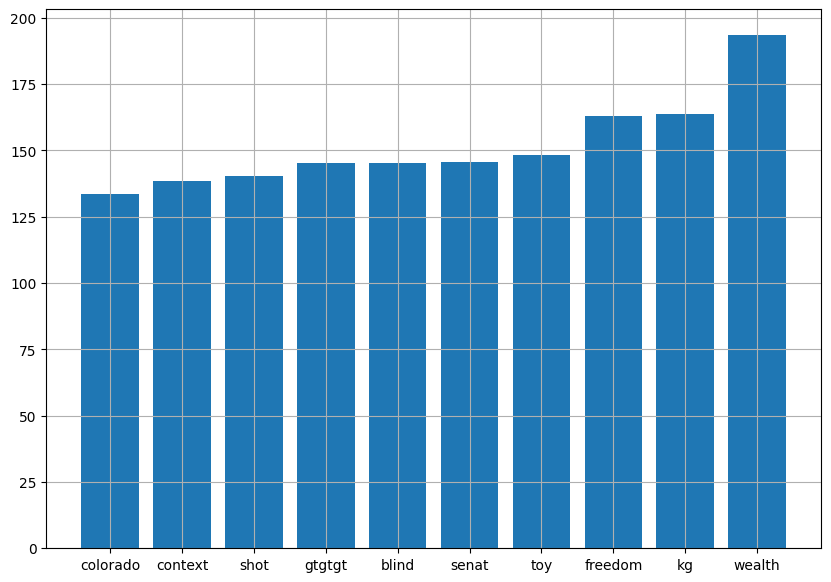

In [208]:
import matplotlib.pyplot as plt

names_max = sorted([(j, i) for i, j in cv_df.vocabulary_.items() if j in max_idxs], key=lambda x: list(max_idxs).index(x[0]))
plt.figure(figsize=(10,7))
plt.grid()
plt.bar(height=sorted(X_test_1.max(axis=0))[-10:], x=[i[1] for i in names_max])

<BarContainer object of 10 artists>

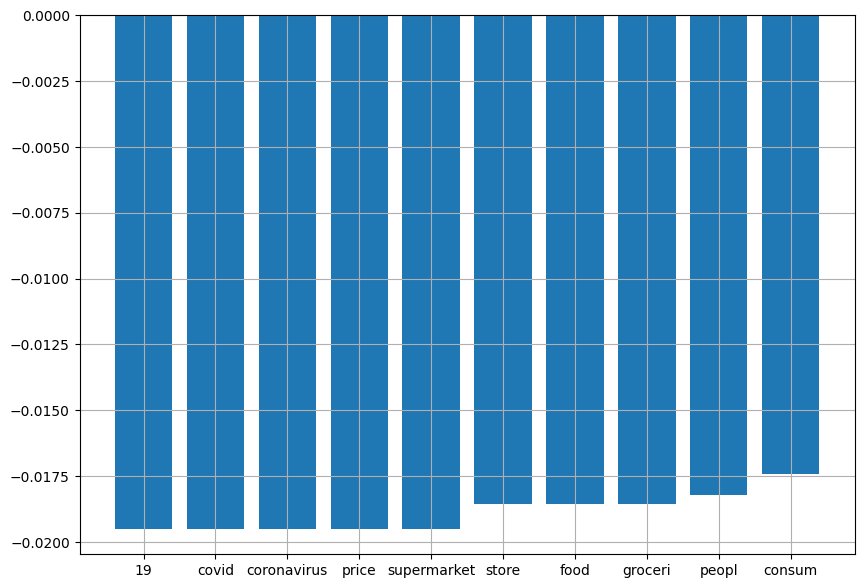

In [209]:
names_min = sorted([(j, i) for i, j in cv_df.vocabulary_.items() if j in min_idxs], key=lambda x: list(min_idxs).index(x[0]))
plt.figure(figsize=(10,7))
plt.grid()
plt.bar(height=sorted(X_test_1.min(axis=0))[-10:], x=[i[1] for i in names_min])

**Ответ:** минимальная значимость у самых частых оторванных от ээмоционабьного окраса слов. Максимальная соответствует словам с кокнретикой

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [210]:
train['UserName'].shape == train['UserName'].unique().shape

True

In [211]:
train['ScreenName'].shape == train['ScreenName'].unique().shape

True

**Ответ:** UserName и ScreenName у каждого твита уникальный, бесполезные признаки

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [212]:
import time
import datetime

convert_to_datetime = lambda x: time.mktime(datetime.datetime.strptime(x, "%d-%m-%Y").timetuple())
train['TweetAt'] = train['TweetAt'].apply(convert_to_datetime)

In [213]:
from seaborn import distplot

<Axes: xlabel='TweetAt', ylabel='Density'>

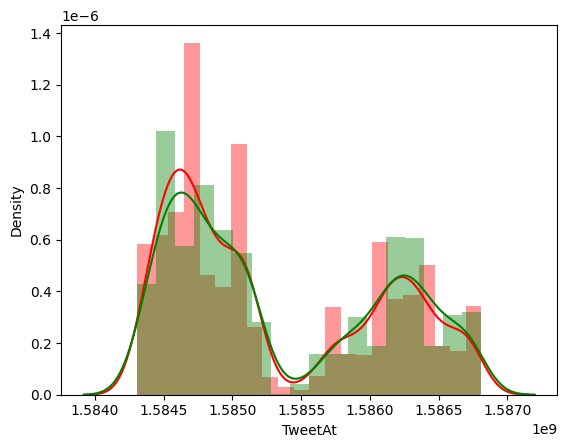

In [214]:
X_1 = train[train['Sentiment'] == 1]['TweetAt']
X_0 = train[train['Sentiment'] == 0]['TweetAt']
distplot(X_0, color='red')
distplot(X_1, color='green')

Не сказал бы, что сильно полезно. Но попробуем

In [215]:
test['TweetAt'] = test['TweetAt'].apply(convert_to_datetime)

In [216]:
X_train, y_train = train.iloc[:, -2], train.iloc[:, -1]
X_test, y_test = test.iloc[:, -2], test.iloc[:, -1]

X_train_1 = cv_df.transform(X_train)
X_test_1 = cv_df.transform(X_test)

X_train_1 = np.hstack([X_train_1.toarray(), train['TweetAt'].values.reshape(-1, 1)])
X_test_1 = np.hstack([X_test_1.toarray(), test['TweetAt'].values.reshape(-1, 1)])

scaler = StandardScaler()

X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.transform(X_test_1)

lr = LogisticRegression()
lr.fit(X_train_1, y_train)

print(f"count vectorizer, 3819 tokens, datetime feature, train : {accuracy_score(y_train, lr.predict(X_train_1)):.3f}")
print(f"count vectorizer, 3819 tokens, datetime feature, test : {accuracy_score(y_test, lr.predict(X_test_1)):.3f}")

count vectorizer, 3819 tokens, datetime feature, train : 0.788
count vectorizer, 3819 tokens, datetime feature, test : 0.663


**Ответ:** Ну да, нот юзфул

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [217]:
location_stats = Counter(train['Location'].values)
len(location_stats)

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

<BarContainer object of 10 artists>

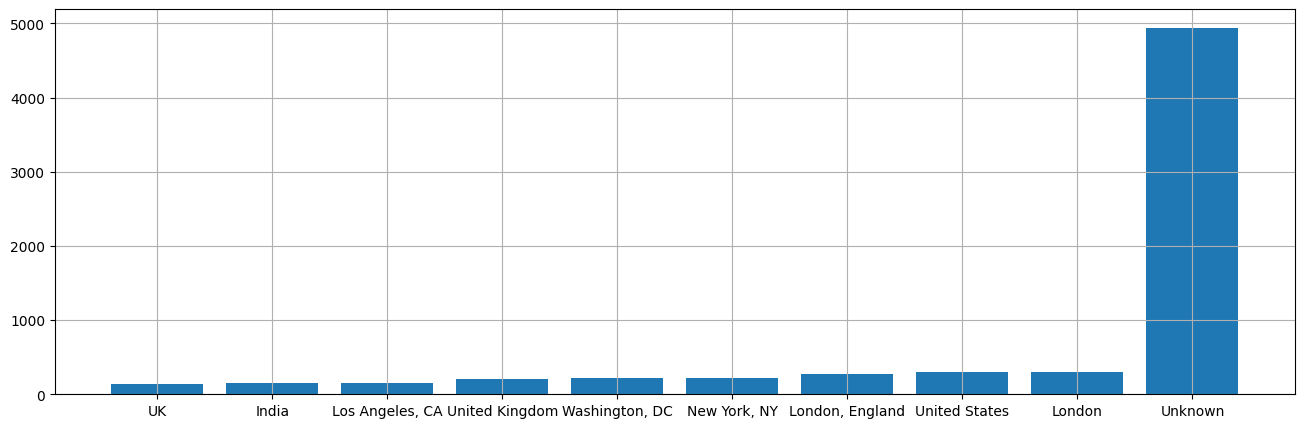

In [218]:
popular_locations = sorted(location_stats.keys(), key=lambda x: location_stats[x])
plt.figure(figsize=(16, 5))
plt.grid()
plt.bar(height=[location_stats[x] for x in popular_locations[-10:]], x=popular_locations[-10:])

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [219]:
US_codes = [
"AL", "KY", "OH", "AK", "LA", "OK", "AZ", "ME", "OR", "AR", "MD", "PA", "AS", "MA", "PR", "CA", "MI", "RI", "CO", 
"MN", "SC", "CT", "MS", "SD", "DE", "MO", "TN", "DC", "MT", "TX", "FL", "NE", "TT", "GA", "NV", "UT", "GU", "NH", 
"VT", "HI", "NJ", "VA", "ID", "NM", "VI", "IL", "NY", "WA", "IN", "NC", "WV", "IA", "ND", "WI", "KS", "MP", "WY",
]

In [ ]:
# for state in US_codes:
#     if state in train['WiderLocation'].values:
#         dff = train[train['WiderLocation'] == state]
#         print(f"{state}: {dff.shape[0]}  {dff['Sentiment'].mean():.3f}")

In [222]:
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(", ")[-1] if not x.split(", ")[-1] in US_codes else 'USA')
location_stats = Counter(train['WiderLocation'].values)
len(location_stats)

4869

<BarContainer object of 10 artists>

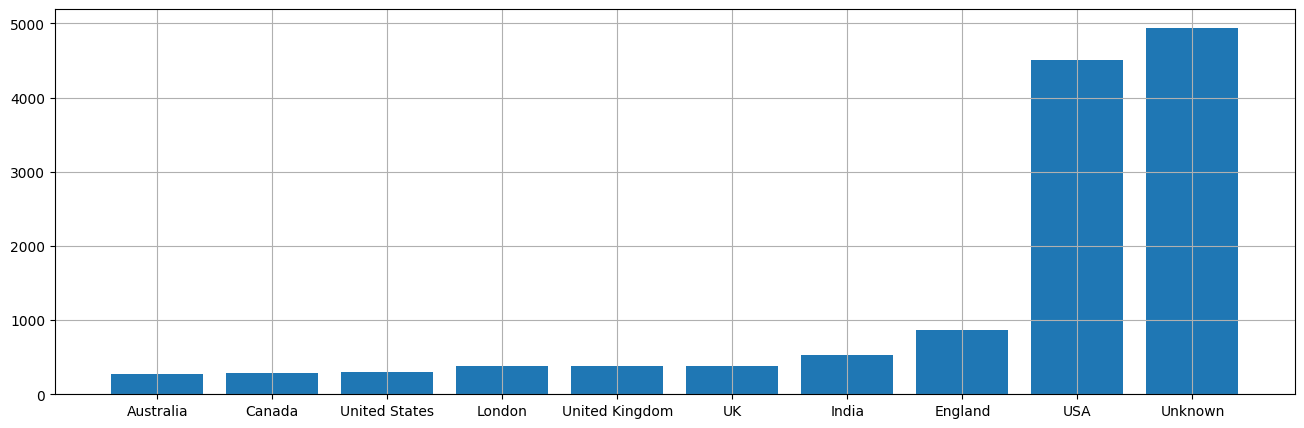

In [223]:
popular_locations = sorted(location_stats.keys(), key=lambda x: location_stats[x])
plt.figure(figsize=(16, 5))
plt.grid()
plt.bar(height=[location_stats[x] for x in popular_locations[-10:]], x=popular_locations[-10:])

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [227]:
good_locations = [i for i in location_stats.keys() if location_stats[i] > 1]
location_OHE = pd.get_dummies(train['WiderLocation'])[good_locations].astype(int)
for col in location_OHE.columns:
    test[col] = (test['Location'].apply(lambda x: x.split(", ")[-1] if not x.split(", ")[-1] in US_codes else 'USA') == col).astype(int)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [230]:
X_train, y_train = train.loc[:, 'OriginalTweet'], train.loc[:, 'Sentiment']
X_test, y_test = test.loc[:, 'OriginalTweet'], test.loc[:, 'Sentiment']

X_train_1 = cv_df.transform(X_train)
X_test_1 = cv_df.transform(X_test)

scaler = StandardScaler()

X_train_1 = scaler.fit_transform(X_train_1.toarray())
X_test_1 = scaler.transform(X_test_1.toarray())

X_train_1 = np.hstack([X_train_1, location_OHE.values])
X_test_1 = np.hstack([X_test_1, test[location_OHE.columns].values])

lr = LogisticRegression()
lr.fit(X_train_1, y_train)

print(f"count vectorizer, 3819 tokens, location feature, train : {accuracy_score(y_train, lr.predict(X_train_1)):.3f}")
print(f"count vectorizer, 3819 tokens, location feature, test : {accuracy_score(y_test, lr.predict(X_test_1)):.3f}")

count vectorizer, 3819 tokens, location feature, train : 0.794
count vectorizer, 3819 tokens, location feature, test : 0.662


**Ответ:** Нет, признак оказался неполезным. Но попробуем ща по штатам ещё разбить

In [231]:
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(", ")[-1])
location_stats = Counter(train['WiderLocation'].values)
len(location_stats)

4921

<BarContainer object of 10 artists>

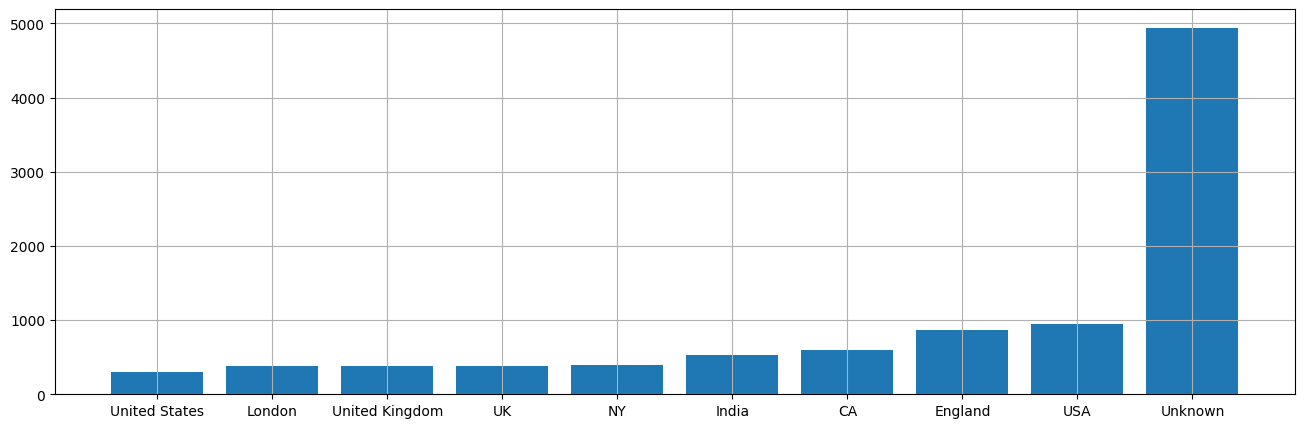

In [232]:
popular_locations = sorted(location_stats.keys(), key=lambda x: location_stats[x])
plt.figure(figsize=(16, 5))
plt.grid()
plt.bar(height=[location_stats[x] for x in popular_locations[-10:]], x=popular_locations[-10:])

In [233]:
good_locations = [i for i in location_stats.keys() if location_stats[i] > 1]
location_OHE = pd.get_dummies(train['WiderLocation'])[good_locations].astype(int)
for col in location_OHE.columns:
    test[col] = (test['Location'].apply(lambda x: x.split(", ")[-1]) == col).astype(int)

In [234]:
X_train, y_train = train.loc[:, 'OriginalTweet'], train.loc[:, 'Sentiment']
X_test, y_test = test.loc[:, 'OriginalTweet'], test.loc[:, 'Sentiment']

X_train_1 = cv_df.transform(X_train)
X_test_1 = cv_df.transform(X_test)

scaler = StandardScaler()

X_train_1 = scaler.fit_transform(X_train_1.toarray())
X_test_1 = scaler.transform(X_test_1.toarray())

X_train_1 = np.hstack([X_train_1, location_OHE.values])
X_test_1 = np.hstack([X_test_1, test[location_OHE.columns].values])

lr = LogisticRegression()
lr.fit(X_train_1, y_train)

print(f"count vectorizer, 3819 tokens, location feature, train : {accuracy_score(y_train, lr.predict(X_train_1)):.3f}")
print(f"count vectorizer, 3819 tokens, location feature, test : {accuracy_score(y_test, lr.predict(X_test_1)):.3f}")

count vectorizer, 3819 tokens, location feature, train : 0.795
count vectorizer, 3819 tokens, location feature, test : 0.660


Лучше не стало

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --